### Import Dependencies

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib
import splitfolders
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

### Dataset Loading and Splitting
- Split-folders library was used to split the dataset into three parts: Training set(70%), Validation set(15%), and Test set(15%).

In [2]:
base_ds = 'D:\Data Science\Deep Learning\CNN\Rice Classification\Rice_Image_Dataset'
base_ds = pathlib.Path(base_ds)

In [3]:
splitfolders.ratio(base_ds, output='imgs', seed=123, ratio=(.70,.15,.15), group_prefix=None)

In [3]:
arborio = [fn for fn in os.listdir(f'{base_ds}/Arborio') if fn.endswith('.jpg')]
bastmati = [fn for fn in os.listdir(f'{base_ds}/Basmati') if fn.endswith('.jpg')]
ipsala = [fn for fn in os.listdir(f'{base_ds}/Ipsala') if fn.endswith('.jpg')]
jasmine = [fn for fn in os.listdir(f'{base_ds}/Jasmine') if fn.endswith('.jpg')]
karacadag = [fn for fn in os.listdir(f'{base_ds}/Karacadag') if fn.endswith('.jpg')]
rice = [arborio, bastmati, ipsala, jasmine, karacadag]
rice_classes = []
for i in os.listdir('imgs/train'):
    rice_classes+=[i]
rice_classes.sort()

In [4]:
rice_classes

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

### Dataset Exploration

Total images: 75000
Total number of classes: 5
Total Arborio images: 15000
Total Basmati images: 15000
Total Ipsala images: 15000
Total Jasmine images: 15000
Total Karacadag images: 15000


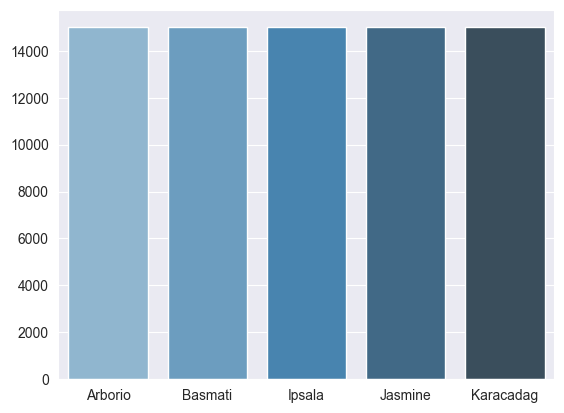

In [5]:
image_count = len(list(base_ds.glob('*/*.jpg')))
print(f'Total images: {image_count}')
print(f'Total number of classes: {len(rice_classes)}')
count = 0
rice_count = []
for x in rice_classes:
    print(f'Total {x} images: {len(rice[count])}')
    rice_count.append(len(rice[count]))
    count += 1

sns.set_style('darkgrid')
sns.barplot(x=rice_classes, y=rice_count, palette="Blues_d")
plt.show()

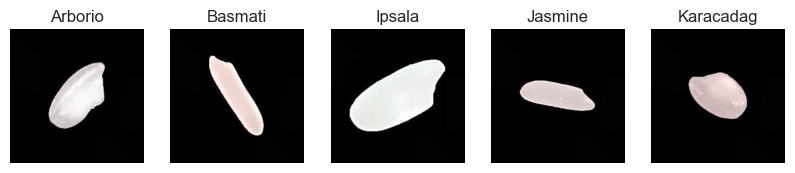

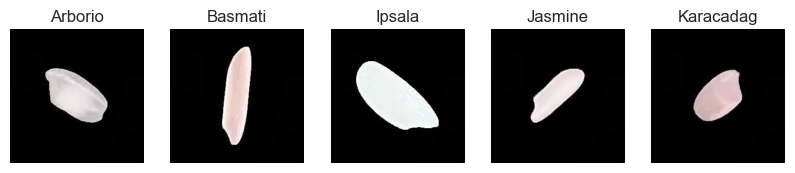

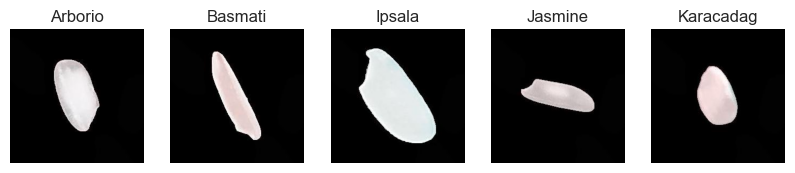

In [7]:
def load_random_img(dir, label):
    plt.figure(figsize=(10,10))
    i=0
    for label in rice_classes:
        i+=1
        plt.subplot(1, 5, i)
        file = random.choice(os.listdir(f'{dir}/{label}'))
        image_path = os.path.join(f'{dir}/{label}', file)
        img=cv2.imread(image_path)
        plt.title(label)
        plt.imshow(img)
        plt.grid(None)
        plt.axis('off')
        
for i in range(3):
    load_random_img(base_ds, rice_classes)

### Data Pre-processing

In [5]:
batch_size = 128
img_height, img_width = 100, 100
input_shape = (img_height, img_width, 3)

In [6]:
datagen = ImageDataGenerator(rescale=1./255)

train_ds = datagen.flow_from_directory(
    'imgs/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    subset = "training",
    class_mode='categorical')

val_ds = datagen.flow_from_directory(
    'imgs/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

test_ds = datagen.flow_from_directory(
    'imgs/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

Found 52500 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.


### Vanilla CNN Model

In [10]:
model_vanilla = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [11]:
model_vanilla.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_vanilla.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 98, 98, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 98, 98, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 98, 98, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                        

In [12]:
history1 = model_vanilla.fit(train_ds, epochs = 10, validation_data = val_ds)

Epoch 1/10
411/411 [==============================] - 3166s 8s/step - loss: 0.0988 - accuracy: 0.9677 - val_loss: 4.0820 - val_accuracy: 0.4908
Epoch 2/10
411/411 [==============================] - 3856s 9s/step - loss: 0.0350 - accuracy: 0.9887 - val_loss: 0.5858 - val_accuracy: 0.7777
Epoch 3/10
411/411 [==============================] - 31654s 77s/step - loss: 0.0284 - accuracy: 0.9911 - val_loss: 2.4068 - val_accuracy: 0.7436
Epoch 4/10
411/411 [==============================] - 9885s 24s/step - loss: 0.0246 - accuracy: 0.9924 - val_loss: 0.3180 - val_accuracy: 0.8708
Epoch 5/10
411/411 [==============================] - 7729s 19s/step - loss: 0.0201 - accuracy: 0.9940 - val_loss: 0.1521 - val_accuracy: 0.9533
Epoch 6/10
411/411 [==============================] - 2996s 7s/step - loss: 0.0184 - accuracy: 0.9938 - val_loss: 0.0329 - val_accuracy: 0.9891
Epoch 7/10
411/411 [==============================] - 3011s 7s/step - loss: 0.0209 - accuracy: 0.9934 - val_loss: 2.0609 - val_accur

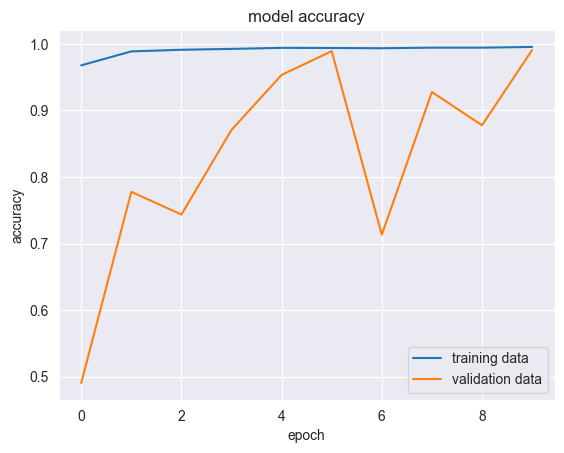

In [19]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend(['training data', 'validation data'], loc = 'lower right')

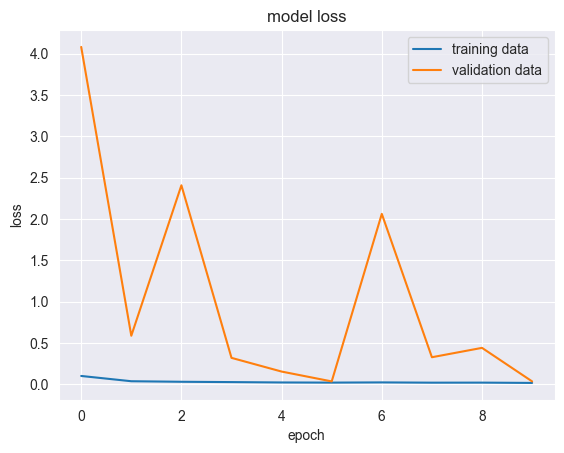

In [22]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['training data', 'validation data'], loc = 'upper right')

### Model Evaluation of Vanilla CNN

In [23]:
score1 = model_vanilla.evaluate(test_ds, verbose=1)

88/88 [==============================] - 211s 2s/step - loss: 0.0350 - accuracy: 0.9908


In [24]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model_vanilla.predict(test_ds)
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
print(confusion_mtx)
print()
report1 = classification_report(test_ds.classes, y_pred, target_names=rice_classes, output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1

88/88 [==============================] - 146s 2s/step
[[2240    0   13    2   16]
 [   0 2189    0    0    0]
 [   0    0 2236    0    0]
 [   9   61    1 2248    0]
 [   1    0    0    0 2234]]



,precision,recall,f1-score,support
Arborio,0.986350,0.995556,0.990931,2250.000000
Basmati,1.000000,0.972889,0.986258,2250.000000
Ipsala,1.000000,0.993778,0.996879,2250.000000
Jasmine,0.969383,0.999111,0.984023,2250.000000
Karacadag,0.999553,0.992889,0.996210,2250.000000
accuracy,0.990844,0.990844,0.990844,0.990844
macro avg,0.991057,0.990844,0.990860,11250.000000
weighted avg,0.991057,0.990844,0.990860,11250.000000


### Transfer Learning - VGG16 Model

In [7]:
vgg = VGG16(include_top=False,weights='imagenet',input_shape=(100,100,3))
vgg.trainable = False
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [8]:
model_vgg16=Sequential()
model_vgg16.add(vgg)
model_vgg16.add(Flatten())
model_vgg16.add(Dense(1024,activation="relu"))
model_vgg16.add(Dense(5,activation="softmax"))

In [9]:
model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_vgg16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 1024)              4719616   
                                                                 
 dense_1 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 19,439,429
Trainable params: 4,724,741
Non-trainable params: 14,714,688
_________________________________________________________________


In [10]:
history2 = model_vgg16.fit(train_ds, epochs = 5, validation_data = val_ds)

Epoch 1/5
411/411 [==============================] - 6825s 17s/step - loss: 0.1037 - accuracy: 0.9683 - val_loss: 0.0442 - val_accuracy: 0.9856
Epoch 2/5
411/411 [==============================] - 38792s 95s/step - loss: 0.0365 - accuracy: 0.9883 - val_loss: 0.0305 - val_accuracy: 0.9896
Epoch 3/5
411/411 [==============================] - 5161s 13s/step - loss: 0.0307 - accuracy: 0.9904 - val_loss: 0.0262 - val_accuracy: 0.9916
Epoch 4/5
411/411 [==============================] - 5699s 14s/step - loss: 0.0294 - accuracy: 0.9901 - val_loss: 0.0340 - val_accuracy: 0.9886
Epoch 5/5
411/411 [==============================] - 5631s 14s/step - loss: 0.0214 - accuracy: 0.9929 - val_loss: 0.0222 - val_accuracy: 0.9934


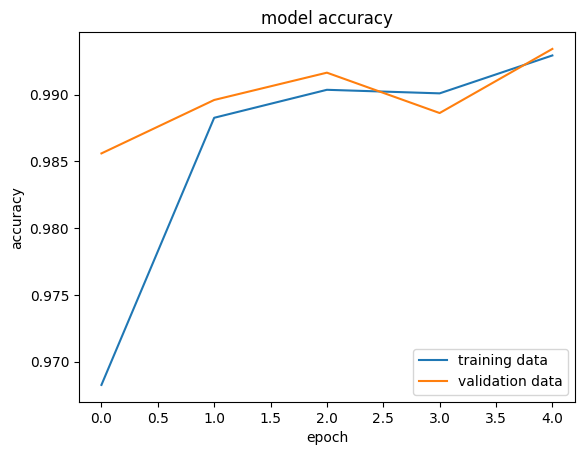

In [12]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend(['training data', 'validation data'], loc = 'lower right')

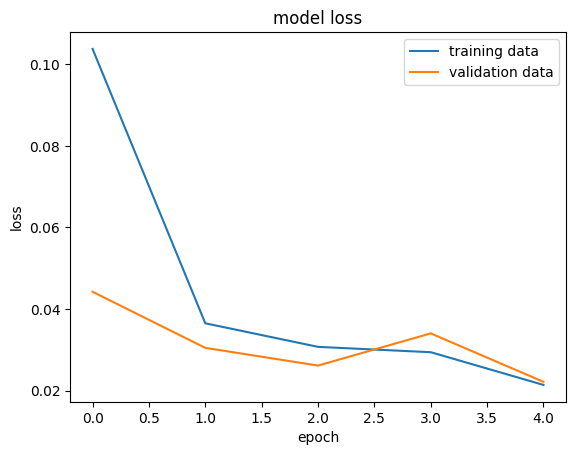

In [13]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['training data', 'validation data'], loc = 'upper right')

### Model Evaluation of VGG16

In [14]:
score2 = model_vgg16.evaluate(test_ds, verbose=1)

88/88 [==============================] - 854s 10s/step - loss: 0.0236 - accuracy: 0.9933


In [15]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model_vgg16.predict(test_ds)
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
print(confusion_mtx)
print()
report2 = classification_report(test_ds.classes, y_pred, target_names=rice_classes, output_dict=True)
df2 = pd.DataFrame(report2).transpose()
df2

88/88 [==============================] - 917s 10s/step
[[2224    0    1    4    3]
 [   0 2218    0    2    0]
 [   0    0 2243    1    0]
 [   5   32    6 2243    0]
 [  21    0    0    0 2247]]



,precision,recall,f1-score,support
Arborio,0.996416,0.988444,0.992414,2250.000000
Basmati,0.999099,0.985778,0.992394,2250.000000
Ipsala,0.999554,0.996889,0.998220,2250.000000
Jasmine,0.981190,0.996889,0.988977,2250.000000
Karacadag,0.990741,0.998667,0.994688,2250.000000
accuracy,0.993333,0.993333,0.993333,0.993333
macro avg,0.993400,0.993333,0.993339,11250.000000
weighted avg,0.993400,0.993333,0.993339,11250.000000


### Model Testing

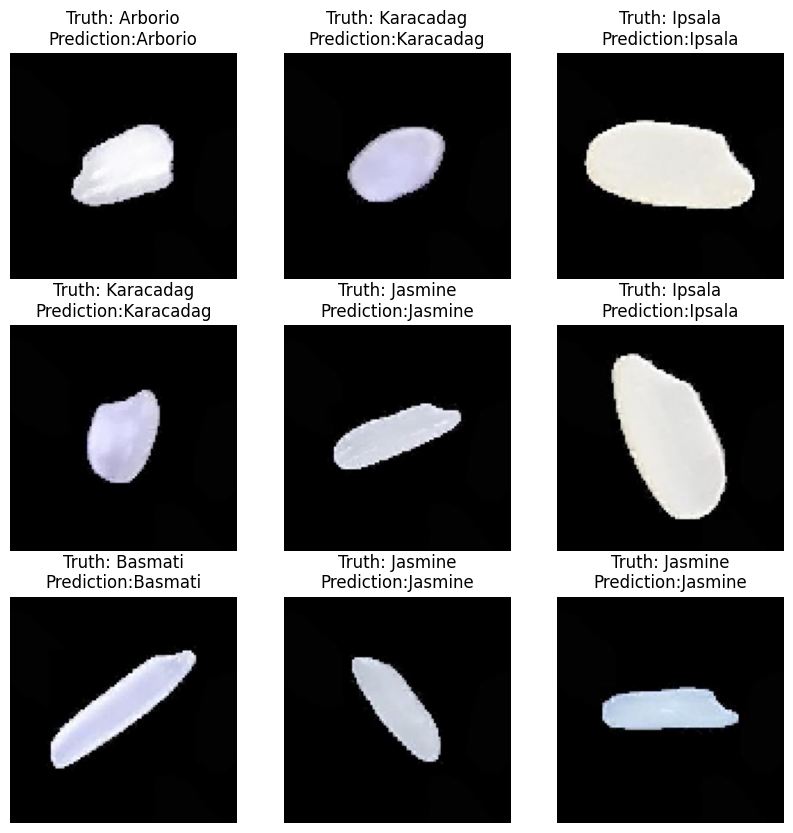

In [19]:
plt.figure(figsize=(10, 10))
x, label= train_ds.next()
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i])
    result = np.where(label[i]==1)
    predict = model_vgg16(tf.expand_dims(x[i], 0))
    score = tf.nn.softmax(predict[0])
    score_label = rice_classes[np.argmax(score)]
    plt.title(f'Truth: {rice_classes[result[0][0]]}\nPrediction:{score_label}')
    plt.axis(False)

### Conclusion -->
- There are two models performed in order to bulid Rice Classification Model. One is **Vanilla CNN Model** & other is **Transfer Learning-VGG16 Model**.
- After performing two models I observed that : 
  1. Vanilla CNN Model :- **Accuracy : 99.08% & Loss : 0.0350**
  2. VGG16 Model :- **Accuracy : 99.33% & Loss : 0.0236**
- Therefore it is concluded that VGG16 model is having high accuracy & low loss and performed well compared to Vanilla CNN model.